In [16]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import LocalOutlierFactor
import functools
import tempfile
import datetime
import tensorflow as tf
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from utils import make_data, make_data_rev, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8258744404992541351
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5458500826840410773
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8700424926632161657
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6285949697959120661
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

## ホールドアウト検証
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

In [3]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)

In [4]:
df_list=[]

window=15
for i in set(df['day']):
    lag=[] 
    lag.append(make_data_rev(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'lstmaed']=0
semi_train_df.loc[:, 'lstmaed_label']=0

In [5]:
semi_train_df

original  original_next1  original_next2  original_next3  \
0            53.4            52.8            52.8            53.2   
1            52.8            52.8            53.2            53.6   
2            52.8            53.2            53.6            54.0   
3            53.2            53.6            54.0            54.7   
4            53.6            54.0            54.7            55.7   
...           ...             ...             ...             ...   
2393321      45.2            45.0            44.6            45.2   
2393322      45.0            44.6            45.2            44.9   
2393323      44.6            45.2            44.9            44.9   
2393324      45.2            44.9            44.9            45.1   
2393325      44.9            44.9            45.1            45.7   

         original_next4  original_next5  original_next6  original_next7  \
0                  53.6            54.0            54.7            55.7   
1                  54.0            54.7            55.7            55.5   
2                  54.7            55.7            55.5            55.7   
3                  55.7            55.5            55.7            55.6   
4                  55.5            55.7            55.6            55.8   
...                 ...             ...             ...             ...   
2393321            44.9            44.9            45.1            45.7   
2393322            44.9            45.1            45.7            45.0   
2393323            45.1            45.7            45.0            45.6   
2393324            45.7            45.0            45.6            45.4   
2393325            45.0            45.6            45.4            44.8   

         original_next8  original_next9  original_next10  original_next11  \
0                  55.5            55.7             55.6             55.8   
1                  55.7            55.6             55.8             55.7   
2                  55.6            55.8             55.7             55.0   
3                  55.8            55.7             55.0             54.9   
4                  55.7            55.0             54.9             54.9   
...                 ...             ...              ...              ...   
2393321            45.0            45.6             45.4             44.8   
2393322            45.6            45.4             44.8             45.1   
2393323            45.4            44.8             45.1             45.4   
2393324            44.8            45.1             45.4             45.0   
2393325            45.1            45.4             45.0             45.2   

         original_next12  original_next13  original_next14  day  label  \
0                   55.7             55.0             54.9    0      0   
1                   55.0             54.9             54.9    0      0   
2                   54.9             54.9             54.9    0      0   
3                   54.9             54.9             55.0    0      0   
4                   54.9             55.0             55.0    0      0   
...                  ...              ...              ...  ...    ...   
2393321             45.1             45.4             45.0    5      0   
2393322             45.4             45.0             45.2    5      0   
2393323             45.0             45.2             45.1    5      0   
2393324             45.2             45.1             45.1    5      0   
2393325             45.1             45.1             46.0    5      0   

         lstmaed  lstmaed_label  
0              0              0  
1              0              0  
2              0              0  
3              0              0  
4              0              0  
...          ...            ...  
2393321        0              0  
2393322        0              0  
2393323        0              0  
2393324        0              0  
2393325        0              0  

[2393326 rows x 19 columns]

## LSTM_autoencoder

In [6]:
units=3
print(f'units:{units}')
LSTM_autoencoder = keras.Sequential()
LSTM_autoencoder.add(keras.layers.LSTM(
    units=units,
    input_shape=(window, 1),
))
# LSTM_autoencoder.add(keras.layers.Dropout(rate=0.5))
LSTM_autoencoder.add(keras.layers.RepeatVector(n=window))
LSTM_autoencoder.add(keras.layers.LSTM(
    units=units, 
    return_sequences=True,
))
# LSTM_autoencoder.add(keras.layers.Dropout(rate=0.5))
LSTM_autoencoder.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=1)
  )
)

units:3


2024/01/05 16:24:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/05 16:24:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/01/05 16:24:54 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目
Epoch 1/100
8226/8226 [==============================] - 62s 7ms/step - loss: 0.0095 - val_loss: 0.0080
Epoch 2/100
8226/8226 [==============================] - 48s 6ms/step - loss: 0.0062 - val_loss: 0.0079
Epoch 3/100
8226/8226 [==============================] - 52s 6ms/step - loss: 0.0061 - val_loss: 0.0077
Epoch 4/100
8226/8226 [==============================] - 53s 6ms/step - loss: 0.0059 - val_loss: 0.0070
Epoch 5/100
8226/8226 [==============================] - 52s 6ms/step - loss: 0.0054 - val_loss: 0.0065
Epoch 6/100
8226/8226 [==============================] - 53s 6ms/step - loss: 0.0052 - val_loss: 0.0065
Epoch 7/100
8226/8226 [==============================] - 53s 6ms/step - loss: 0.0052 - val_loss: 0.0063
Epoch 8/100
8226/8226 [==============================] - 52s 6ms/step - loss: 0.0052 - val_loss: 0.0064
Epoch 9/100
8226/8226 [==============================] - 52s 6ms/step - loss: 0.0051 - val_loss: 0.0063
Epoch 10/100
8226/8226 [===

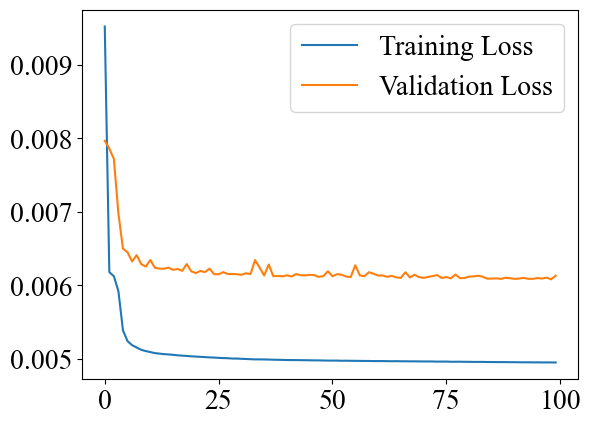

8984/8984 [==============================] - 21s 2ms/step
------------------------------------------------------


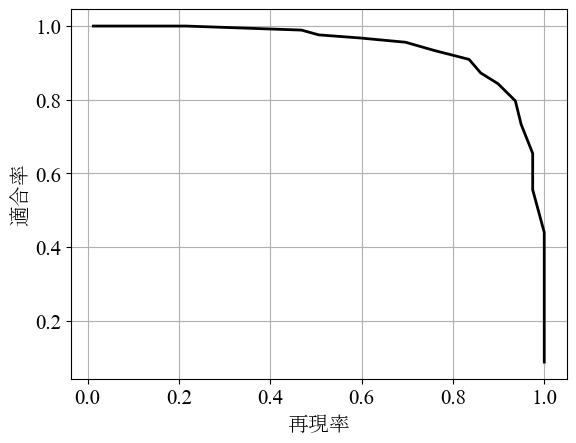

AUC：0.9310746182833992
理想の閾値：0.4
F値（最高）：0.8708719267888703
適合率（F値が最高の時）：0.9094387755102041
再現率（F値が最高の時）：0.8354430379746836
C:\Users\Arakawa\AppData\Local\Temp\tmpavti77mr\predict_results.png


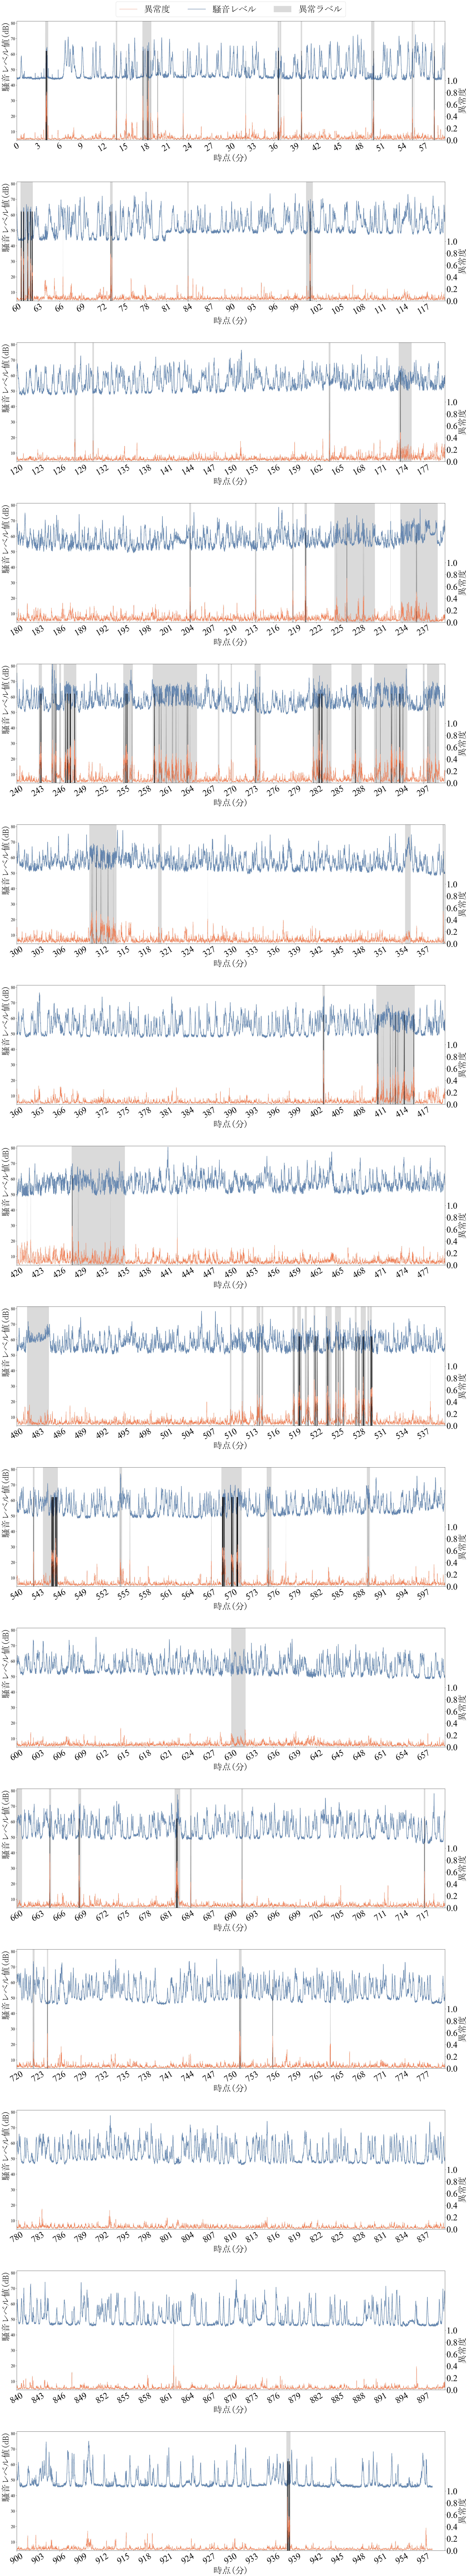

1/1 [==============================] - 0s 16ms/step


INFO:tensorflow:Assets written to: C:\Users\Arakawa\AppData\Local\Temp\tmpw8oddbc_\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Arakawa\AppData\Local\Temp\tmpw8oddbc_\model\data\model\assets
C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'LSTM_autoencoder' already exists. Creating a new version of this model...
Created version '75' of model 'LSTM_autoencoder'.


In [7]:
mlflow.autolog(log_models=False)

# 実験をアクティブ化(設定)する。ない場合は新たな実験を作成してアクティブ化する
mlflow.set_experiment("units")
run_name='result'
with mlflow.start_run(run_name=run_name):

    # テストデータとする日
    i=[1]
    label_train_day=[k for k in semi_train_day if k not in i]
    label_grant_day=i
    print(f'訓練データ：{label_train_day}')
    print(f'ラベル付与データ：{label_grant_day}日目')
    # Log the hyperparameters
    mlflow.log_params({'trainday':label_train_day, 'testday':label_grant_day, 
                       'window_size':window, 'units':units})

    semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
    labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
    # tf.reduce_min関数を使用して、train_dataテンソル内の最小値を計算しています。
    # min_valにはtrain_data内の最小値が代入されます。
    min_val = tf.reduce_min(semi_train_x)
    # tf.reduce_max関数を使用して、train_dataテンソル内の最大値を計算しています。
    # max_valにはtrain_data内の最大値が代入されます。
    max_val = tf.reduce_max(semi_train_x)
    train_data = (semi_train_x.values - min_val) / (max_val - min_val)
    labeling_data = (labeling_x.values - min_val) / (max_val - min_val)

    # データをモデルに入力する形状に整形し,データの型をtf.float32に変換
    train_data = tf.cast(train_data[:, :, np.newaxis], tf.float32)
    labeling_data = tf.cast(labeling_data[:, :, np.newaxis], tf.float32)

    LSTM_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                             loss='mae')

    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        restore_best_weights=True
    )
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = LSTM_autoencoder.fit(train_data, train_data, 
          epochs=100, 
          batch_size=256,
          validation_data=(labeling_data, labeling_data),
          callbacks=[callback],
          shuffle=True)

    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

    reconstructions = LSTM_autoencoder.predict(labeling_data)
    #     異常度算出
    d= tf.keras.losses.mae(reconstructions[:, :, 0], labeling_data[:, :, 0]).numpy()
    semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'lstmaed']=d
    print('------------------------------------------------------')

    test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)
    d_test=(d-d.min())/(d.max()-d.min())

    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
    f_max=f_score.max()
    p_max=p_score[np.argmax(f_score)]
    r_max=r_score[np.argmax(f_score)]
    print('\033[31m'+f'AUC：{auc}'+'\033[0m')
    print(f'理想の閾値：{thr}')
    print(f'F値（最高）：{f_max}')
    print(f'適合率（F値が最高の時）：{p_max}')
    print(f'再現率（F値が最高の時）：{r_max}')

    # Log the loss metric
    mlflow.log_metric("test_AUC", auc)
    mlflow.log_metric("test_Fscore_best", f_max)
    mlflow.log_metric("test_Precision_when Fscore Best", p_max)
    mlflow.log_metric("test_Recall_when Fscore Best", r_max)

    # 一時ディレクトリに予測結果のグラフを保存して，mlflowに送信する
    with tempfile.TemporaryDirectory()  as tmp:
        filename = os.path.join(tmp, "predict_results.png")
        plot_timeseries([test_v['original'].values], test_v['label'].values, d=d_test, thr=thr, mlflow=filename)
        mlflow.log_artifact(filename, artifact_path="plot_timeseries")

#     モデルの構造を定義しているソースコードを保存
    mlflow.log_artifact('LSTM_autoencoder_HO.ipynb', artifact_path="source_code")    
    # Log the model
    signature= infer_signature(labeling_data.numpy()[:2], LSTM_autoencoder.predict(labeling_data.numpy()[:2]))
    input_example= labeling_data.numpy()[:2]
    mlflow.tensorflow.log_model(
        LSTM_autoencoder, 
        artifact_path="LSTM_autoencoder",
        signature=signature,
        registered_model_name="LSTM_autoencoder",
        input_example= input_example
    )

In [8]:
! mlflow gc --backend-store-uri ./mlruns

Run with ID 626e45fe872845b1a7cce33e29836f3b has been permanently deleted.
Run with ID 1ecc256d7b534346b41769def07d4a25 has been permanently deleted.
Run with ID 0912d373034c41cea78ace6d6444605e has been permanently deleted.
Run with ID e59f651de88e41678f3e14ae4130ee22 has been permanently deleted.
Run with ID d0c352ed165148eb9b139beb035e01d0 has been permanently deleted.


In [9]:
! mlflow ui --port 5004 

^C


## 異常度可視化

In [19]:
def figure_detail(df_test, d_test, start=0, stop=60):
    plt.rcParams["font.size"] = 22
    plt.rcParams["font.family"] = "Times New Roman"
    
    start_data=int(math.floor(start)*60/0.2)
    stop_data=int(math.ceil(stop)*60/0.2)

    test_plot=df_test['original'].values[start_data:stop_data]
    d=d_test[start_data:stop_data]
    label=df_test['label'].values[start_data:stop_data]*100
    label_index=range(len(label))
    time=[t*0.2/60 for t in range(start_data, stop_data)]
    fig, ax=plt.subplots(1, 1, figsize=(35, 7))
    ax.plot(time, test_plot, color='#6687AF' ,linewidth = 3, label='Noise Level')
    ax2=ax.twinx()
    ax2.plot(time, d, color='#F17B51',linewidth = 3, label='Anomaly Score')
    ax.fill_between(time, label,  facecolor='#D9D9D9', label='Abnormal period' )
    ax.set_xticks(np.arange(math.floor(start), math.ceil(stop), 5))
    ax.set_xticklabels(np.arange(math.floor(start), math.ceil(stop), 5), fontsize=50)
#     ax.xaxis.set_tick_params(rotation=30)
    ax.set_xlim(start, stop)
    ax.set_yticks(np.arange(40, 90, 10))
    ax.set_yticklabels(np.arange(40, 90, 10), fontsize=60)        
    ax.set_ylim(40, 80)
    ax2.set_yticks(np.arange(0, 12, 2)/10)
    ax2.set_yticklabels(np.arange(0, 12, 2)/10, fontsize=60)
    ax2.set_ylim(0, 1)
    ax.set_ylim(30, 80)
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h2+h1, l2+l1, loc='upper center', bbox_to_anchor=(.5, 1.4), ncol=3, prop={'family':"MS Mincho", 'size':60})
    ax.set_xlabel('Time(min)', fontfamily="MS Mincho",fontsize=60)
    ax.set_ylabel('Noise Level', fontfamily="MS Mincho",fontsize=60, loc='bottom')
    ax2.set_ylabel('Anomaly Score', fontfamily="MS Mincho",fontsize=60, loc='bottom')
#     plt.grid(True)
    plt.show()  

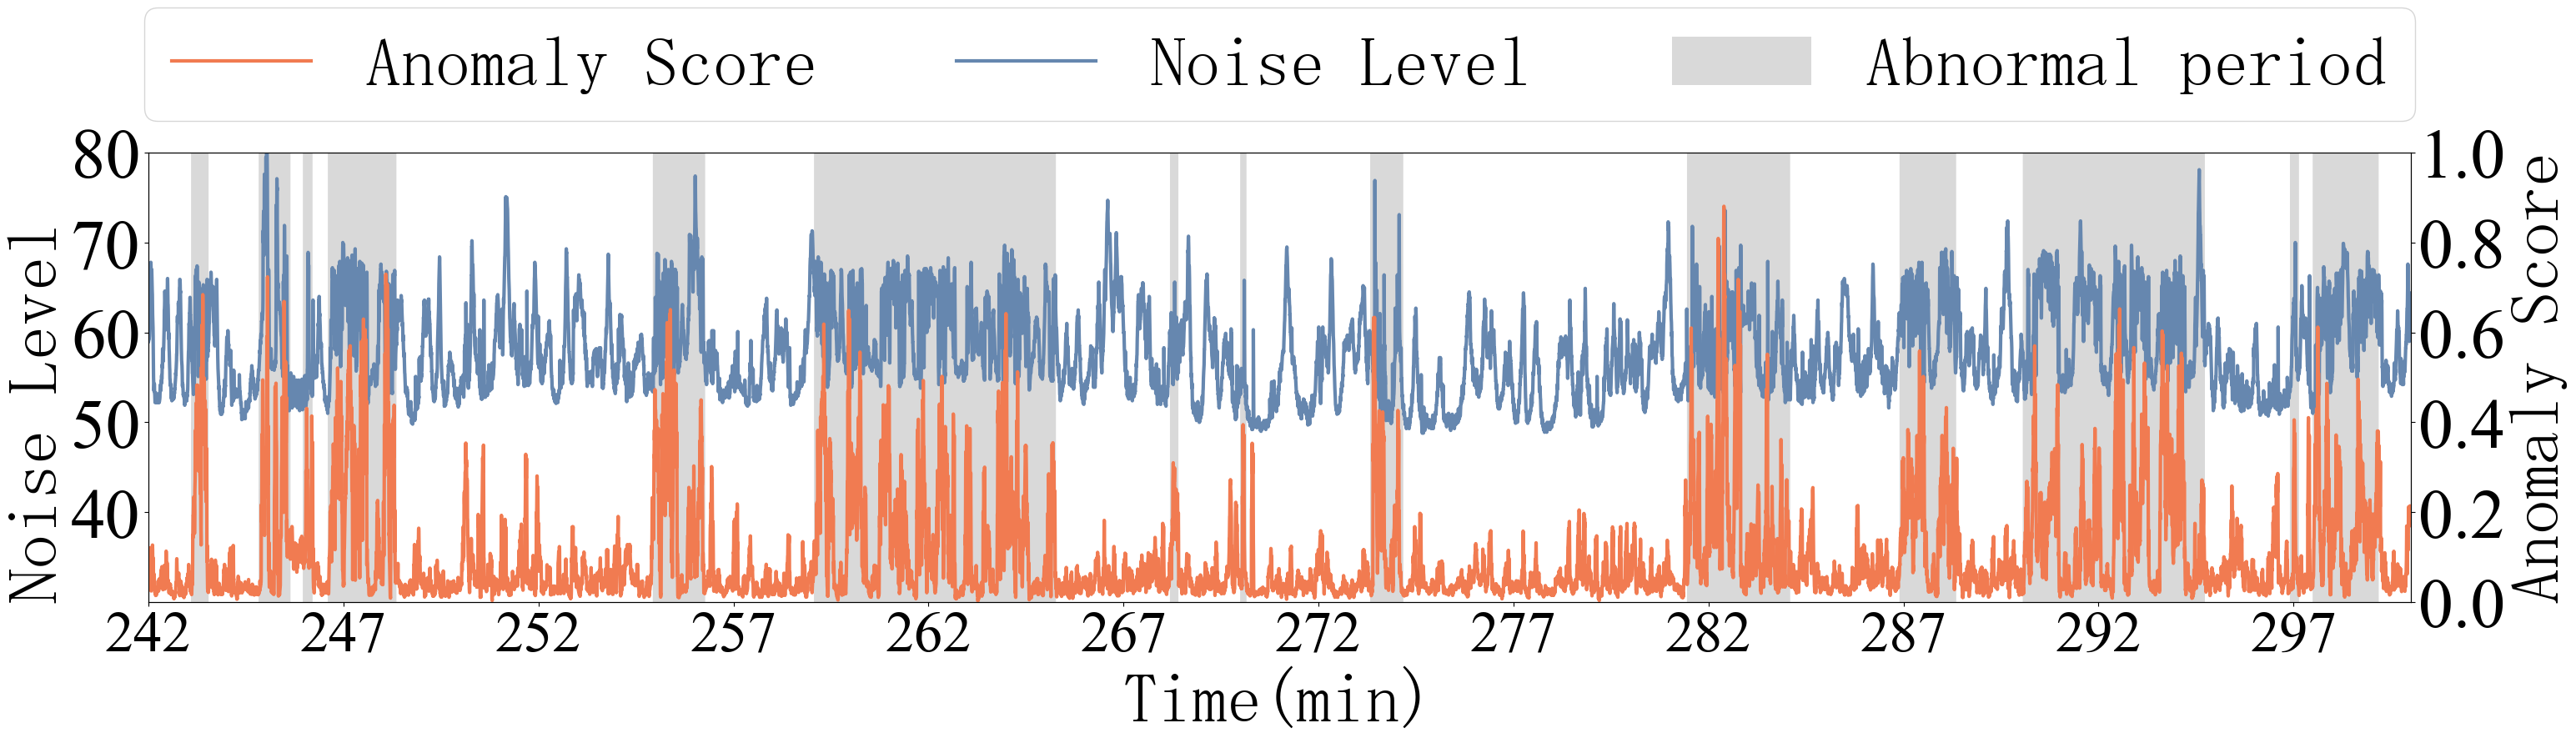

In [20]:
start=242
stop=300
figure_detail(test_v, d_test, start, stop)